In [109]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import random
import time
import os
import pandas as pd
import math
import bcolz
import pickle
import re

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
print("Pytorch: {}".format(torch.__version__))

Pytorch: 0.2.0_4


# Data loading

In [21]:
all_data_org = pd.read_csv('data/en_train_org.csv')

In [22]:
all_data_org[pd.isnull(all_data_org['before'])][:3]

,sentence_id,token_id,class,before,after
616107,49226,17,LETTERS,NaN,n a
684691,54634,1,PLAIN,NaN,NaN
965529,76612,7,PLAIN,NaN,NaN


In [129]:
all_data = all_data_org.dropna()
print("Data rows: {},  (dropped none rows: {})".format(len(all_data), len(all_data_org)-len(all_data)))
all_data = all_data[all_data['class'] != 'VERBATIM']
print("Data rows: {},  (dropped rows: {})".format(len(all_data), len(all_data_org)-len(all_data)))
all_data = all_data.reset_index(drop=True)

Data rows: 9918390,  (dropped none rows: 51)
Data rows: 9840282,  (dropped rows: 78159)


Note we dropped VERBATIM class. Thats because it had so many weird characters.

In [863]:
all_data_sentence_index = all_data.set_index('sentence_id')

### More balanced sample

In [589]:
all_data.groupby("class")["class"].count()

class
ADDRESS           522
CARDINAL       133744
DATE           258348
DECIMAL          9821
DIGIT            5442
ELECTRONIC       5162
FRACTION         1196
LETTERS        152790
MEASURE         14783
MONEY            6128
ORDINAL         12703
PLAIN         7353647
PUNCT         1880507
TELEPHONE        4024
TIME             1465
Name: class, dtype: int64

In [590]:
all_data_classes = list(all_data.groupby('class'))

In [591]:
all_data_classes[0][1].sample(2).append(all_data_classes[1][1].sample(2))

,sentence_id,token_id,class,before,after
4091242,316676,0,ADDRESS,C175,c one seven five
6840198,523681,6,ADDRESS,A68,a sixty eight
4390367,339231,0,CARDINAL,444,four hundred forty four
6536657,500958,3,CARDINAL,33,thirty three


In [592]:
data_balanced_classes = pd.concat([v.sample(min(50000, len(v))) for k, v in all_data_classes])

In [593]:
data_balanced_classes.groupby("class")["class"].count()

class
ADDRESS         522
CARDINAL      50000
DATE          50000
DECIMAL        9821
DIGIT          5442
ELECTRONIC     5162
FRACTION       1196
LETTERS       50000
MEASURE       14783
MONEY          6128
ORDINAL       12703
PLAIN         50000
PUNCT         50000
TELEPHONE      4024
TIME           1465
Name: class, dtype: int64

In [594]:
data_balanced_classes.sample(10)

,sentence_id,token_id,class,before,after
1488820,117774,7,PLAIN,males,males
6866902,525698,1,ORDINAL,I's,the first's
10265,844,16,LETTERS,ISBN,i s b n
8145230,621667,21,PUNCT,.,.
1517580,119988,6,PUNCT,.,.
2060221,161781,19,MEASURE,36%,thirty six percent
6900848,528237,14,PUNCT,.,.
3561924,276478,4,ORDINAL,8th,eighth
3618343,280781,5,PLAIN,household,household
7125473,545048,4,PLAIN,relatively,relatively


In [600]:
test = data_balanced_classes.sample(10)
test

,sentence_id,token_id,class,before,after
5084593,391788,9,DATE,1962,nineteen sixty two
9776955,743366,11,DATE,1957,nineteen fifty seven
5111960,393837,0,DATE,"December 15, 1988",december fifteenth nineteen eighty eight
5201898,400653,0,ELECTRONIC,Saturnfans.com,s a t u r n f a n s dot c o m
4991684,384765,10,PLAIN,room,room
8215193,626871,9,MONEY,US$14,fourteen dollars
3295076,256162,10,MEASURE,57.3/km²,fifty seven point three per square kilometers
1459473,115520,4,CARDINAL,182,one hundred eighty two
1850061,145592,18,DATE,December 2007,december two thousand seven
8280862,631801,7,DATE,1992,nineteen ninety two


In [633]:
data_balanced_classes_matrix = data_balanced_classes.as_matrix()

In [626]:
%%timeit
data_balanced_classes.sample(1)

4.7 ms ± 32.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [632]:
%%timeit
data_balanced_classes.iloc[random.randint(1, len(test)-1)]

98.1 µs ± 1.25 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [627]:
%%timeit
data_balanced_classes_matrix[random.randint(1, len(test)-1)]

1.61 µs ± 11.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


# Word vectors

In [12]:
def load_glove(name):
    with open(name, 'r') as f: lines = [line.split() for line in f]
    words = [d[0] for d in lines]
    vecs = np.stack(np.array(d[1:], dtype=np.float32) for d in lines)
    wordidx = {o:i for i,o in enumerate(words)}
    return vecs, words, wordidx

In [15]:
wv_vecs, wv_words, wv_idx = load_glove('/home/ohu/koodi/data/glove_wordvec/glove.6B.50d.txt')

In [354]:
wv_max_words = len(wv_words)
print("Original last word:", wv_words[wv_max_words - 1])

Original last word: sandberger


In [372]:
wv_vecs = np.concatenate((wv_vecs, np.zeros([1, 50], dtype=np.float32)), axis=0)
wv_words.append('SAMPLE')
wv_idx['SAMPLE'] = wv_words.index('SAMPLE')

In [253]:
re_apos = re.compile(r"(\w)'s\b")         # make 's a separate word
re_mw_punc = re.compile(r"(\w[’'])(\w)")  # other ' in a word creates 2 words
re_punc = re.compile("([\"().,;:/_?!—])") # add spaces around punctuation
re_mult_space = re.compile(r"  *")        # replace multiple spaces with just one

def simple_tokeniser(sent):
    sent = re_apos.sub(r"\1 's", sent)
    sent = re_mw_punc.sub(r"\1 \2", sent)
    sent = re_punc.sub(r" \1 ", sent).replace('-', ' - ')
    sent = re_punc.sub(r" \1 ", sent)
    sent = re_mult_space.sub(' ', sent)
    return sent.lower().split()
simple_tokeniser("asdf's   asdf   -testaaa")

['asdf', "'s", 'asdf', '-', 'testaaa']

In [256]:
arr = [simple_tokeniser(s_)[0] for s_ in list(all_data.sample(1000)['before'])]
[s in wv_idx for s in arr].count(True) / 1000

0.983

In [979]:
def get_random_sample():
    sample_row = data_balanced_classes.iloc[random.randint(1, len(data_balanced_classes)-1)]
    sentence_id = sample_row['class']

    #rows = all_data[all_data['sentence_id']==sample_row['sentence_id']]
    rows = all_data_sentence_index.loc[sample_row['sentence_id']]
    befores = rows.before.values
        
    token_id_idx = list(rows['token_id']).index(sample_row['token_id'])
    befores[token_id_idx] = '*****'
    str_list = simple_tokeniser(' '.join(befores))
    
    word_vect = np.zeros((1, len(str_list), wv_vecs.shape[1]), dtype=np.float32)
    # var = np.zeros((1, len(str_list), wv_vecs.shape[1]+1))
    for i, w in enumerate(str_list):
        if w=='*****':
            word_vect[0][i] = np.zeros((1, wv_vecs.shape[1]))
        else:
            try:
                word_vect[0][i] = wv_vecs[wv_idx[w]]
            except KeyError:
                word_vect[0][i] = np.random.rand(1, wv_vecs.shape[1])
    return sample_row['before'], sample_row['after'], sample_row['class'], word_vect
            
# get_random_sample()
s_bef, s_aft, s_class, s_word_v = get_random_sample()
print(s_class, ':', s_bef, '->', s_aft, ':', s_word_v.shape, type(s_word_v[0,0,0]))

LETTERS : M. -> m : (1, 16, 50) <class 'numpy.float32'>


In [972]:
%%timeit
get_random_sample()

523 µs ± 29.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Other data stuff

In [900]:
categories_all = all_data["class"].unique()
print(categories_all)
print(len(categories_all))
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['PLAIN' 'PUNCT' 'DATE' 'LETTERS' 'CARDINAL' 'DECIMAL' 'MEASURE' 'MONEY'
 'ORDINAL' 'TIME' 'ELECTRONIC' 'DIGIT' 'FRACTION' 'TELEPHONE' 'ADDRESS']
15


# Model

In [1070]:
use_cuda = False

In [1074]:
class LSTM_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(LSTM_RNN, self).__init__()

        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.rnn = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
        self.lin_1 = nn.Linear(hidden_size, output_size)

    def forward(self, word, hidden = None, init_hidden = True):
        if init_hidden:
            hidden = self.init_hidden()
        all_outputs, hidden = self.rnn(word, hidden)
        output = all_outputs[:, -1]
        output = self.lin_1(output)
        output = F.log_softmax(output)
        return output

    def init_hidden(self):
        var1 = Variable(torch.zeros(1, self.n_layers, self.hidden_size))
        var2 = Variable(torch.zeros(1, self.n_layers, self.hidden_size))
        if use_cuda:
            var1 = var1.cuda()
            var2 = var2.cuda()
        return (var1, var2)

s_bef, s_aft, s_class, s_word_v = get_random_sample()
sample = s_word_v
input_size = sample.shape[-1]
model = LSTM_RNN(input_size=input_size, hidden_size=128, output_size=len(categories_all))
print('Sample size:', sample.shape)
output = model(Variable(torch.from_numpy(sample)))
print('Output:', output.size())

Sample size: (1, 22, 50)
Output: torch.Size([1, 15])


In [1075]:
input_size

50

In [958]:
tmp = use_cuda
use_cuda = True
model.cuda()
output = model(Variable(torch.from_numpy(sample)).cuda())
use_cuda = tmp
type(output.data)

torch.cuda.FloatTensor

In [1039]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1)
    category_i = top_i[0][0]
    return categories_all[category_i], category_i

print(category_from_output(output))

('TIME', 9)


### Accuracy

In [1040]:
def test_model_accuracy(model, n_sample=10000):
    model.eval()
    n_correct = 0
    for iteration in range(n_sample):
        s_bef, s_aft, s_class, s_word_v = get_random_sample()
        # category, line, category_tensor, line_tensor = randomTrainingExample()
        s_word_v = Variable(torch.from_numpy(s_word_v))
        if use_cuda:
            s_word_v = s_word_v.cuda()
        output = model(s_word_v)
        if s_class == category_from_output(output)[0]:
            n_correct += 1

    print("Accuracy: {:>4.2%} ({:>8d}/{:>8d})".format(
            n_correct/n_sample, n_correct, n_sample))

In [1041]:
%%time
test_model_accuracy(model, n_sample=1000)

Accuracy: 9.90% (      99/    1000)
CPU times: user 1.35 s, sys: 20 ms, total: 1.37 s
Wall time: 1.38 s


# Training

In [1046]:
def train(model, category, word_vect):
    category_tensor = Variable(torch.LongTensor([categories_index[category]]))
    word_vect = Variable(torch.from_numpy(word_vect))
    if use_cuda:
        category_tensor = category_tensor.cuda()
        word_vect = word_vect.cuda()
            
    output = model(word_vect)
    loss = loss_function(output, category_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.data[0]

In [1047]:
s_bef, s_aft, s_class, s_word_v = get_random_sample()
train(model, s_class, s_word_v)

(Variable containing:
 
 Columns 0 to 9 
 -2.6612 -2.6769 -2.7813 -2.6767 -2.8029 -2.6793 -2.7122 -2.7035 -2.8107 -2.6233
 
 Columns 10 to 14 
 -2.7729 -2.7306 -2.6544 -2.7190 -2.6402
 [torch.cuda.FloatTensor of size 1x15 (GPU 0)], 2.7812905311584473)

In [1048]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [1054]:
def train_iterations(n_iters=100000, start_iter=0, print_every=5000, plot_every=1000):
    model.train()
    start = time.time()
    all_losses = []
    current_loss = 0
    current_loss_iter = 0

    for iteration in range(1, n_iters + 1):
        s_bef, s_aft, s_class, s_word_v = get_random_sample()

        output, loss = train(model, s_class, s_word_v)
        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            guess, guess_i = category_from_output(output)
            correct = '✓' if guess == s_class else "✗ ({})".format(s_class)
            print("{:>6d} {:>4.0%} ({:>8}) {:>6.2f}   | {:>6.2f}: {} -> {} {}".format(
                (iteration+start_iter), iteration/n_iters, timeSince(start),
                current_loss/current_loss_iter, loss,
                s_bef, guess, correct ))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
            current_loss_iter = 0
    
    test_model_accuracy(model, n_sample=10000)
    return all_losses

In [1057]:
model = model.cuda()
use_cuda = True
loss_function = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
all_losses = train_iterations()

  5000   5% (  0m 14s)   1.73   |   1.85: " -> PLAIN ✗ (PUNCT)
 10000  10% (  0m 28s)   1.69   |   2.46: 12th -> CARDINAL ✗ (ORDINAL)
 15000  15% (  0m 42s)   1.57   |   0.02: 2010 -> DATE ✓
 20000  20% (  0m 57s)   1.42   |   1.46: 8th -> CARDINAL ✗ (ORDINAL)
 25000  25% (  1m 12s)   1.34   |   1.78: J. -> PLAIN ✗ (LETTERS)
 30000  30% (  1m 27s)   1.31   |   0.31: . -> PUNCT ✓
 35000  35% (  1m 42s)   1.29   |   0.12: .200 -> DECIMAL ✓
 40000  40% (  1m 56s)   1.21   |   0.54: 16 -> CARDINAL ✓
 45000  45% (  2m 11s)   1.25   |   0.06: . -> PUNCT ✓
 50000  50% (  2m 26s)   1.26   |   4.00: Iouliana -> LETTERS ✗ (PLAIN)
 55000  55% (  2m 40s)   1.27   |   0.83: , -> PLAIN ✗ (PUNCT)
 60000  60% (  2m 54s)   1.18   |   2.13: 2011 -> PUNCT ✗ (DATE)
 65000  65% (   3m 8s)   1.17   |   5.03: 100MB -> PUNCT ✗ (MEASURE)
 70000  70% (  3m 22s)   1.19   |   3.04: 26 January 2012 -> LETTERS ✗ (DATE)
 75000  75% (  3m 36s)   1.11   |   3.41: 1800 -> MEASURE ✗ (DATE)
 80000  80% (  3m 50s)   1.17 

In [1058]:
all_losses_2 = train_iterations(n_iters=200000, start_iter=100000, print_every=20000)

120000  10% (  0m 56s)   1.15   |   0.55: BAPH- -> LETTERS ✓
140000  20% (  1m 53s)   1.14   |   0.78: Pechersky -> PLAIN ✓
160000  30% (  2m 50s)   1.14   |   0.00: Oct. 22, 2007 -> DATE ✓
180000  40% (  3m 48s)   1.14   |   1.48: Genuki.org.uk -> PLAIN ✗ (ELECTRONIC)
200000  50% (  4m 44s)   1.12   |   3.94: 1992 -> LETTERS ✗ (DATE)
220000  60% (  5m 40s)   1.13   |   0.28: 0.024 -> DECIMAL ✓
240000  70% (  6m 36s)   1.11   |   0.36: £75,000 -> MONEY ✓
260000  80% (  7m 34s)   1.12   |   1.30: AC -> LETTERS ✓
280000  90% (  8m 31s)   1.17   |   0.01: 16 March 1965 -> DATE ✓
300000 100% (  9m 27s)   1.18   |   0.90: ESPN -> LETTERS ✓
Accuracy: 60.92% (    6092/   10000)


In [1063]:
test_model_accuracy(model, n_sample=10000)

Accuracy: 61.44% (    6144/   10000)


### Results eval

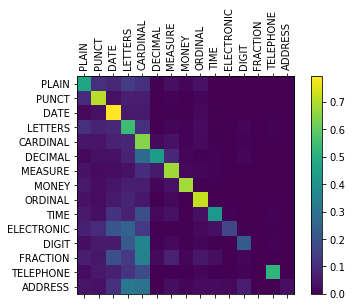

In [1062]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(len(categories_all), len(categories_all))
n_confusion = 100000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    s_bef, s_aft, s_class, s_word_vs = get_random_sample()
    word_vects = Variable(torch.from_numpy(s_word_vs))
    if use_cuda:
        word_vects = word_vects.cuda()
    output = model(word_vects)
    guess, guess_i = category_from_output(output)
    category_i = categories_index[s_class]
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(len(categories_all)):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + list(categories_all), rotation=90)
ax.set_yticklabels([''] + list(categories_all))

# Force label at every tick
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()